In [1]:
from bunkadata import bunka_twitter, bunka_reddit
from bunkatech.nested_topic_modeling import nested_topic_modeling
import plotly
import os
import bamboolib

from bunkadata.graphdb.extract_entity import get_wikidata_id
from bunkadata.scraping.wikidata.wikidata import get_instance_func, get_feature_func
from bunkadata.scraping.wikipedia.wikipedia import get_wikipedia_page_from_wikidata, get_wiki_abstract

from bunkatech.specificity import specificity
import pandas as pd
import numpy as np

from tqdm import tqdm
tqdm.pandas()

#### Extract Data from different sources

In [4]:
%%time
df_twitter = bunka_twitter(
    search_query="ukraine",
    limit=100,
    output_path="data_scraped",
    save_to_graph=True,
    date_min = "2022-02-26",
    date_max = "2022-02-27",
)

Searching for "ukraine lang:en until:2022-02-27 since:2022-02-26"
Serializing data into a Knowledge Graph: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [00:00<00:00, 730.04it/s]
2022-02-27 14:47:07,280  - BUNKA -  : Process over!
2022-02-27 14:47:07,280 - INFO : Process over!


CPU times: user 1.91 s, sys: 108 ms, total: 2.02 s
Wall time: 7.95 s


In [5]:
df_twitter

id  \
0   https://bunka.com/1497723149953159171   
1   https://bunka.com/1497723149646974978   
2   https://bunka.com/1497723148506075136   
3   https://bunka.com/1497723148443205635   
4   https://bunka.com/1497723147667361792   
..                                    ...   
95  https://bunka.com/1497723122493100039   
96  https://bunka.com/1497723122287534087   
97  https://bunka.com/1497723122128015363   
98  https://bunka.com/1497723121951858695   
99  https://bunka.com/1497723121897558024   

                                                 text  
0   @alexshyba @chrisnash All I can think of is al...  
1   Incredibly disheartening sight from the @CNN l...  
2   Dear Russian People: Putin lies. There are no ...  
3   It’s pretty funny the massive support for Ukra...  
4          @svpino Do research about 2014 in Ukraine.  
..                                                ...  
95  Ukraine does not need slaughter-bots. \n\nUkra...  
96  @ZelenskyyUa @BorisJohnson The minds and thoug...  
97  #ThisShitRightHere \nBullshit!  \nTrump HATED ...  
98  @rhonda_harbison @LoraAneM @GOP @RealBenCarson...  
99  And yeah, and my father's side is from Ukraine...  

[100 rows x 2 columns]

In [7]:
# df_twitter = pd.read_csv('data_scraped/scraped_tweets.csv')
df_twitter = df_twitter[df_twitter['text'] != 'nan'].reset_index(drop=True)
df_twitter = df_twitter[['id', 'text']]
df_twitter['source'] = 'twitter'

In [8]:
df_reddit = bunka_reddit(
    sorting_strategy="search",
    query="ukraine",
    limit=10,
    sort="hot",
    path="data_scraped",
    subreddit_name="citypop",
    save_images=False,
    save_to_graph=True,
    client_id=os.getenv("REDDIT_CLIENT_ID"),
    client_secret=os.getenv("REDDIT_CLIENT_SECRET"),
    user_agent=os.getenv("REDDIT_USER_AGENT"),
)


Serializing data into a Knowledge Graph: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1102/1102 [00:00<00:00, 1177.25it/s]
2022-02-27 14:48:55,013 - INFO : Data Serialized into a Knowledge Graph!
2022-02-27 14:48:55,092 - INFO : Process over!


In [9]:
# df_reddit = pd.read_csv('data_scraped/comments.csv', sep = '\t')
df_reddit = df_reddit.rename(columns = {'body':'text'})
df_reddit = df_reddit[['id', 'text']]
df_reddit['source'] = 'reddit'
df_reddit

id  \
0     https://bunka.com/hylqgs3   
1     https://bunka.com/hyltifc   
2     https://bunka.com/hylteoi   
3     https://bunka.com/hylqxz0   
4     https://bunka.com/hylti8e   
...                         ...   
1097  https://bunka.com/hymqc7i   
1098  https://bunka.com/hymqnvj   
1099  https://bunka.com/hymqqws   
1100  https://bunka.com/hymr8mj   
1101  https://bunka.com/hymtk20   

                                                   text  source  
0                                  This guy does it all  reddit  
1              “The most interesting man in the world.”  reddit  
2     A dance off vs Putin is the obvious solution t...  reddit  
3                                    Captain Ukraine 🇺🇦  reddit  
4                   Stop, I can only admire him so much  reddit  
...                                                 ...     ...  
1097  Check another box on Putin's war crimes bingo ...  reddit  
1098  Is Putin playing war crime bingo? So far he's ...  reddit  
1099  >which experts say could be used to carry out ...  reddit  
1100  Seriously. The amount of warcrimes that have b...  reddit  
1101  Believe it or not, flame throwers are not actu...  reddit  

[1102 rows x 3 columns]

#### Merge the Datasets

In [26]:
data = pd.concat([df_twitter.sample(1000, replace=True), df_reddit.sample(1000, replace=True)]).reset_index(drop=True)
data = pd.concat([df_twitter, df_reddit]).reset_index(drop=True)

#### Compute the maps

In [31]:
model = nested_topic_modeling()
bunka = model.fit(
    data,
    text_var="text",
    index_var="id",
    sample_size=4000,
    sample_terms=2000,
    embeddings_model="sbert",
    ngrams=(2, 2),
    ents=False,
    language="en",
    db_path=".",
)


2022-02-27 14:57:57,319 - INFO : Load pretrained SentenceTransformer: distiluse-base-multilingual-cased-v1


Embeddings..


2022-02-27 14:58:06,371 - INFO : Use pytorch device: cpu


Territory embedding..


Batches:   0%|          | 0/38 [00:00<?, ?it/s]

Reducing the vectors..
UMAP(angular_rp_forest=True, metric='cosine', n_components=5, n_neighbors=10, verbose=True)
Sun Feb 27 14:59:00 2022 Construct fuzzy simplicial set
Sun Feb 27 14:59:02 2022 Finding Nearest Neighbors
Sun Feb 27 14:59:03 2022 Finished Nearest Neighbor Search
Sun Feb 27 14:59:03 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Feb 27 14:59:06 2022 Finished embedding


Extract Terms: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1140/1140 [00:10<00:00, 110.83it/s]


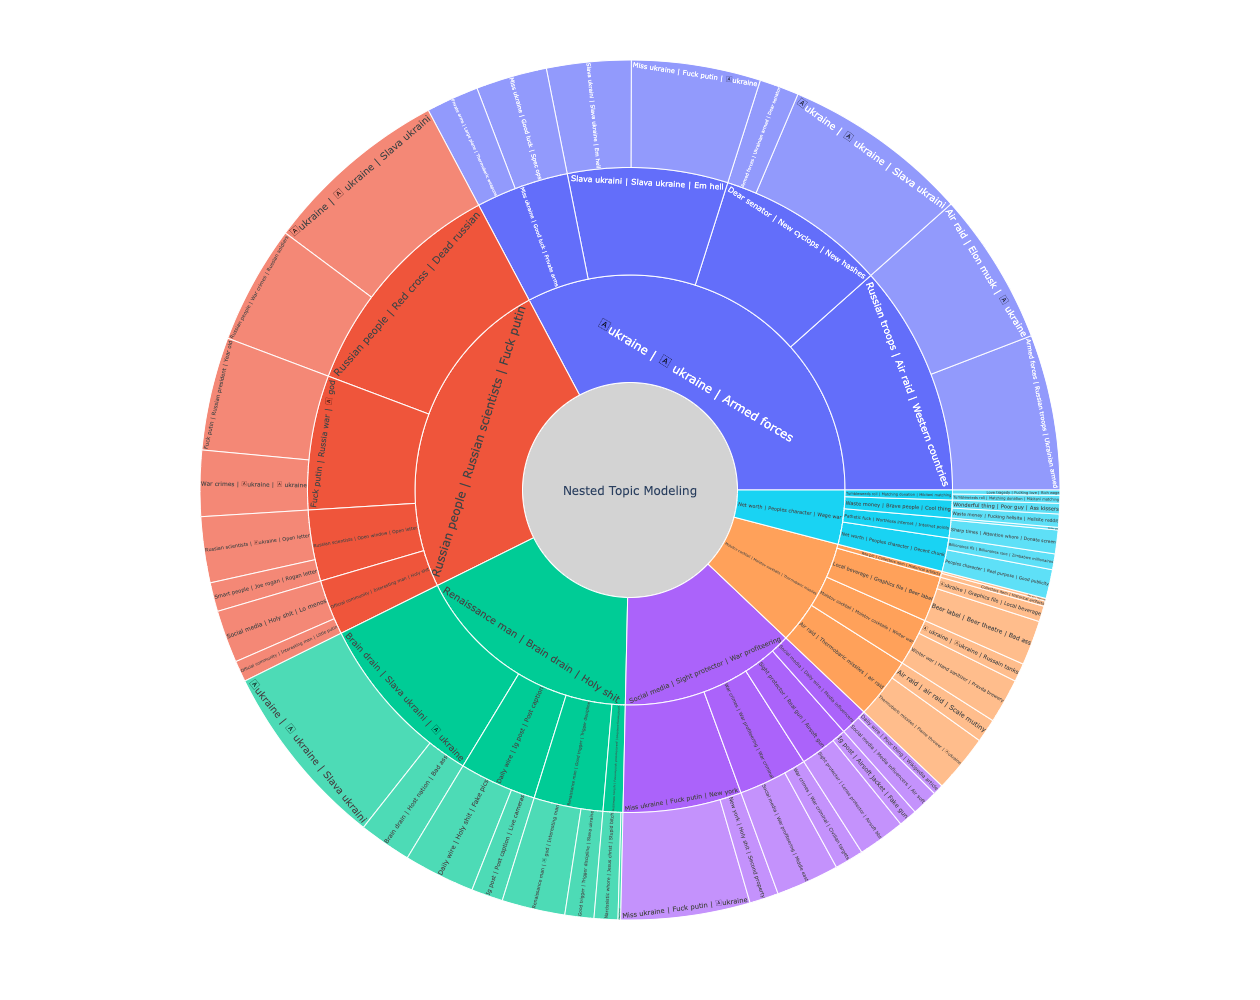

In [32]:
bunka.sunburst

In [35]:
terms = bunka.terms
terms

lemma         main form  \
0       russian people    Russian people   
1            war crime        War crimes   
2     molotov cocktail  Molotov cocktail   
3           fuck putin        Fuck putin   
4        slava ukraini     Slava ukraini   
...                ...               ...   
1642         good info         Good info   
1643         good idea         Good idea   
1644        good fight        Good fight   
1645    good equipment    Best equipment   
1646                🇷🇮                🇷🇮   

                                                   text  ent  count_terms  \
0                       Russian People | Russian people  NaN           18   
1                   war crimes | war crime | War crimes  NaN           15   
2     molotov cocktail | Molotov Cocktail | Molotov ...  NaN           14   
3                  Fuck Putin | fuck Putin | Fuck putin  NaN           11   
4         Slava Ukraini | SLAVA UKRAINI | slava ukraini  NaN           10   
...                                                 ...  ...          ...   
1642                                          good info  NaN            1   
1643                                          good idea  NaN            1   
1644                                         good fight  NaN            1   
1645                                     best equipment  NaN            1   
1646                                                 🇷🇮  NaN            1   

            chi2  
0     132.475756  
1      79.974152  
2      75.608442  
3      61.102291  
4      56.417651  
...          ...  
1642    7.346513  
1643    7.346513  
1644    7.346513  
1645    7.346513  
1646   22.039540  

[1647 rows x 6 columns]

In [6]:
clusters = bunka.h_clusters_names
spec_platform = pd.merge(clusters, data, on = 'id')
_,_, res = specificity(spec_platform, X = 'lemma_2', Y = 'source', Z=None, top_n = 1)
res

lemma_2   source       spec
0     @iaponomarenko | Iaponomarenko | Horrible   reddit   1.386326
1                 Air force | Closed | Airspace  twitter  25.624297
2                       Best | Safe | Good luck   reddit  19.977550
3                    China | Sanctions | Taiwan  twitter   7.603236
4                   Family | Prayers | Thoughts   reddit  15.240415
5                           Force | War | Crime   reddit   0.457738
6                          Fox | Ukraine | News   reddit  12.827826
7                            Free | Ammo | Fear   reddit   3.494750
8                     Fuck putin | Putin | Fuck   reddit  30.100731
9                          Fucking | Nato | War   reddit   0.566376
10                       Kyiv | Airport | Force   reddit   0.581932
11                       Lol | Ukrainian | Blow   reddit   6.452280
12                         Love | Fucking | War   reddit  10.275098
13                    Media | Conflict | Social  twitter   1.944377
14                        Nato | @nato | Member  twitter   9.972701
15                       People | Old | Russian  twitter   0.315144
16                       Poor | People | Prices   reddit  23.455726
17                      Pray | Invasion | Media  twitter   0.073130
18                         President | Help | T   reddit   2.474878
19                  President | Russian | Putin  twitter  32.336467
20                    Prices | Gas | Gas prices  twitter  17.825130
21                Prices | Security | Emergency   reddit   0.257980
22                         Respect | Guy | Like   reddit  45.145362
23                     Right | Countries | Shit   reddit   0.635637
24                    Russia | Nato | Countries  twitter   0.620131
25                           Russia | Putin | T   reddit   0.664000
26  Russian federation | Federation | President  twitter  23.008696
27     Russian | Convention | Geneva convention   reddit   8.978160
28    Russian | Russian soldiers | Russian army  twitter   0.121701
29                      Russian | War | Missile   reddit   0.775190
30                    Sanctions | Biden | Putin  twitter   3.778146
31          Sanctions | Ukraine crisis | Crisis  twitter  14.768720
32                    Sanctions | Way | Fucking   reddit   0.106045
33         Security council | Youtube | Council  twitter  17.302297
34                            Shit | Man | Like   reddit  31.940635
35                      Slava | Putin | Ukraini   reddit   2.471018
36                        Stand | God | Ukraine   reddit   1.262087
37                 State | President | Military  twitter  31.678023
38                            T | Reddit | ️the   reddit   2.696817
39                      Trump | Office | Genius  twitter  29.210535
40                   Twitter | Commander | Army  twitter   5.742354
41                                            U   reddit   0.539363
42                           U | World | Troops   reddit   1.282683
43                   Ukraine | @ukraine | Party   reddit   0.000660
44                    Ukraine | Nato | Millions  twitter   1.340705
45                     Ukrainian | Media | Time   reddit   7.551088
46                          Video | Twitter | T  twitter   4.636621
47              Україні | Слава україні | Слава  twitter   0.016491

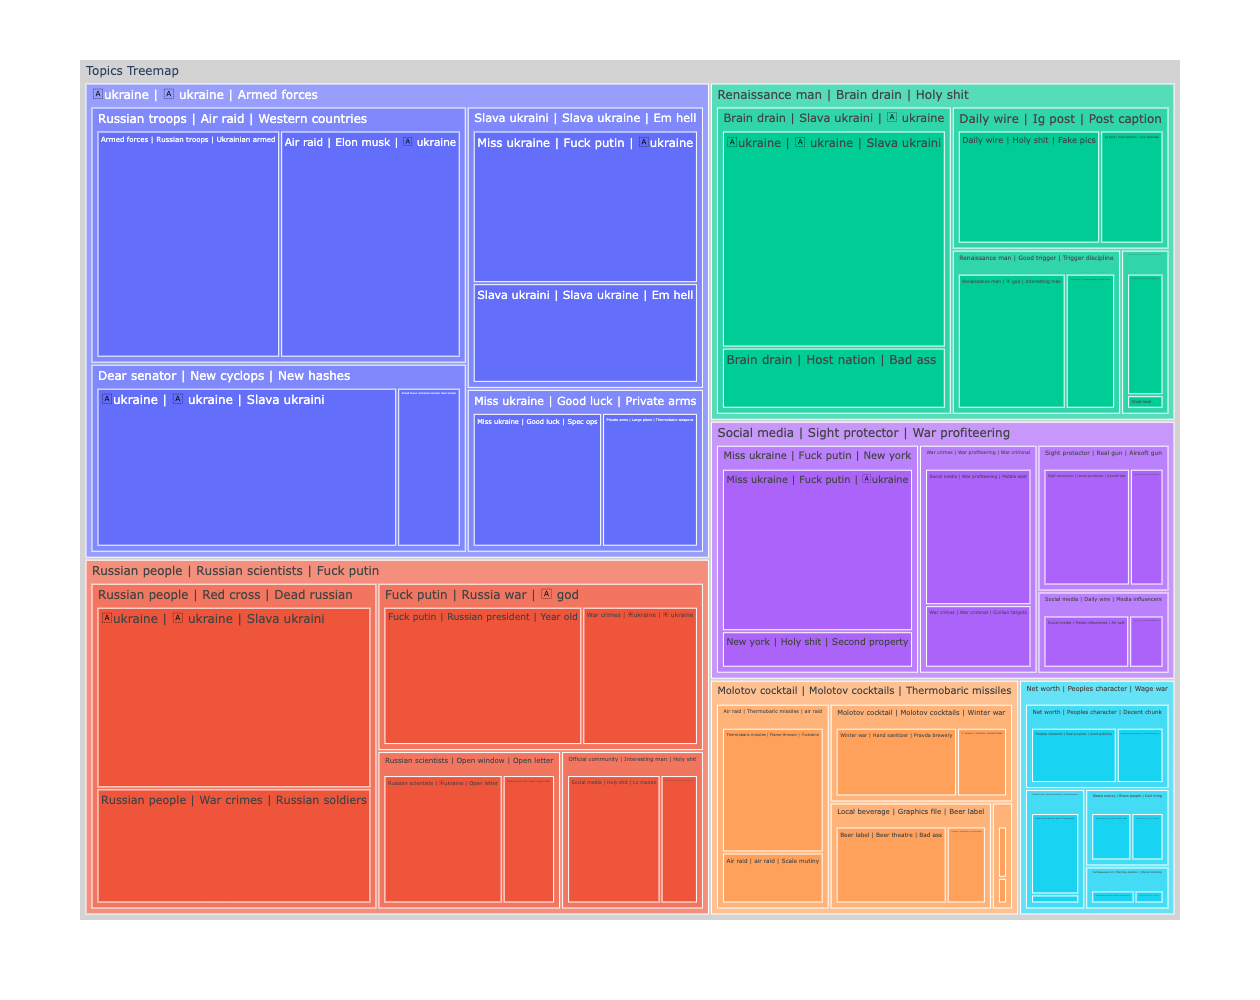

In [36]:
#plotly.offline.plot(bunka.sunburst, auto_open=True, filename="sunburst.html")
#plotly.offline.plot(bunka.sankey, auto_open=True, filename="sankey.html")
#plotly.offline.plot(bunka.treemap, auto_open=True, filename="treemap.html")

bunka.treemap

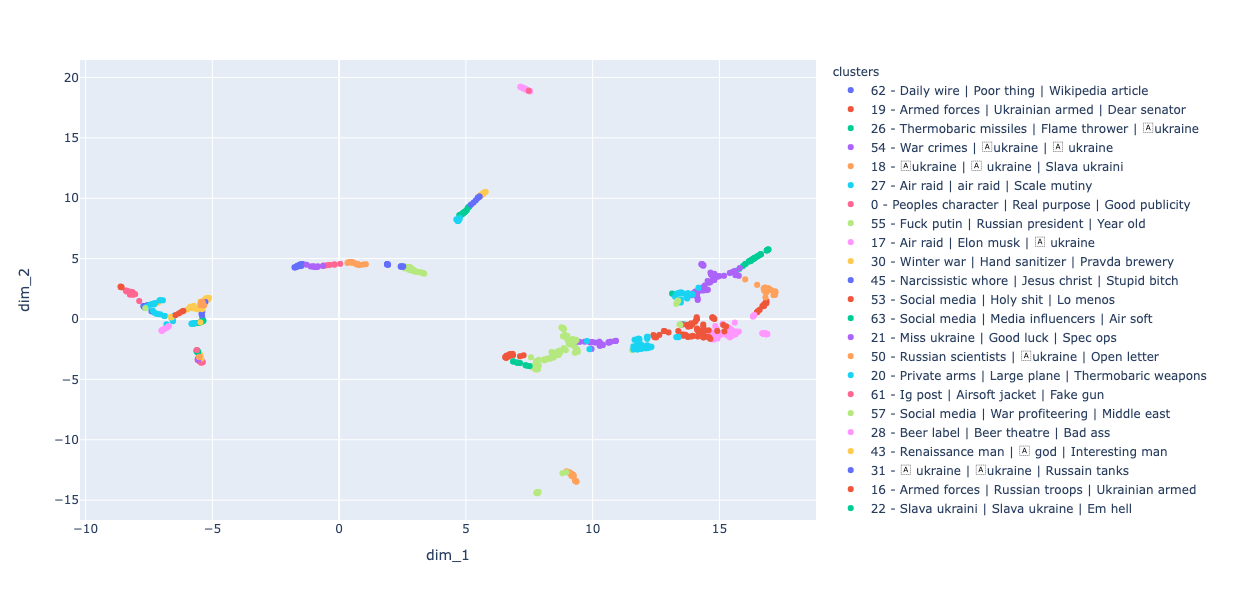

In [37]:
fig = model.visualize_embeddings(nested_level = 2 , width = 1000, height = 600)
fig.show()

In [14]:
#df_centroid = model.get_centroid_documents(nested_level = 2, top_elements = 10)
#df_centroid[df_centroid['clusters']==63]['centroid_docs'].values

#### Get the Wikidata subclass

In [7]:
terms = bunka.terms.copy()[:1000]
#terms['text'] = terms['text'].apply(lambda x: x.split(' | '))
#terms = terms.explode('text')
#terms['text'] = terms['text'].apply(lambda x: x.lower().title())
#terms = terms.drop_duplicates()
terms

lemma main form                                     text  ent  \
0     ukraine   Ukraine    ukraine | Ukraine | UKRAINE | uKrAiNe  NaN   
1      russia    Russia                 Russia | russia | RUSSIA  NaN   
2       putin     Putin  Putin | PUTIN | putin | putins | Putins  NaN   
3     russian   Russian   Russian | russian | RUSSIAN | russians  NaN   
4      people    People       people | PEOPLE | People | peoples  NaN   
..        ...       ...                                      ...  ...   
995       bob       Bob                                      Bob  NaN   
996    outlet    Outlet                         outlet | outlets  NaN   
997  powerful  Powerful                                 powerful  NaN   
998      tiny      Tiny                                     tiny  NaN   
999  blockade  Blockade                      blockade | Blockade  NaN   

     count_terms         chi2  
0           1141  2113.572574  
1            413  1265.576469  
2            363  1143.140586  
3            247   891.668390  
4            203   795.743518  
..           ...          ...  
995            3    21.645324  
996            3    22.508370  
997            3    21.645324  
998            3    21.645324  
999            3    22.508370  

[1000 rows x 6 columns]

In [8]:
# Get the wikidata_ids of terms (takes the longest time)
terms['wikidata_id'] = terms['main form'].progress_apply(lambda x : get_wikidata_id(x))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:55<00:00,  3.38it/s]


In [9]:
#from bunkadata.scraping.wikidata.wikidata import get_feature_func

In [17]:
new_terms = terms[['main form', 'wikidata_id', 'count_terms']].dropna().drop_duplicates().reset_index(drop=True)
new_terms

main form wikidata_id  count_terms
0     Ukraine        Q212         1141
1      Russia        Q159          413
2       Putin       Q7747          363
3     Russian     Q122263          247
4      People    Q2472587          203
..        ...         ...          ...
925       Bob     Q832635            3
926    Outlet    Q7112160            3
927  Powerful     Q398902            3
928      Tiny    Q1039180            3
929  Blockade     Q273976            3

[930 rows x 3 columns]

In [18]:
# Get the instance of the wikidata_ids
new_terms['sublass_of'] = new_terms['wikidata_id'].progress_apply(lambda x: get_feature_func(x, feature_id='P279'))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 930/930 [04:20<00:00,  3.58it/s]


In [28]:
df_sub = new_terms.dropna()
test = df_sub.groupby('sublass_of')['count_terms'].sum().reset_index().sort_values('count_terms').reset_index(drop=True)

In [35]:
indexed_terms = bunka.indexed_terms
indexed_terms

docs              lemma  \
0                                                 какие?              какие   
1      I seem to remember all this starting long befo...            ukraine   
2      Some Russians are protesting Putin's attack on...            ukraine   
3      @MBonghanow @ZoryaLondonsk Coat of arms of Ukr...            ukraine   
4      @MarshaBlackburn You mean it's not Ukraine's f...            ukraine   
...                                                  ...                ...   
91702  So. Now i seen White and Red bands on the russ...  military exercise   
91703  UK PM Boris Johnson announces new sanctions ag...       new sanction   
91704  UK PM Boris Johnson announces new sanctions ag...           pm boris   
91705  UK PM Boris Johnson announces new sanctions ag...              uk pm   
91706  So leftists are okay with occupied areas of Uk...            leftist   

               main form               text  
0                  Какие              какие  
1                Ukraine            ukraine  
2                Ukraine            ukraine  
3                Ukraine            ukraine  
4                Ukraine            ukraine  
...                  ...                ...  
91702  Military exercise  military exercise  
91703      New sanctions      new sanctions  
91704           Pm boris           PM Boris  
91705              Uk pm              UK PM  
91706            Leftist           leftists  

[91707 rows x 4 columns]

In [33]:
terms

lemma main form                                     text  ent  \
0     ukraine   Ukraine    ukraine | Ukraine | UKRAINE | uKrAiNe  NaN   
1      russia    Russia                 Russia | russia | RUSSIA  NaN   
2       putin     Putin  Putin | PUTIN | putin | putins | Putins  NaN   
3     russian   Russian   Russian | russian | RUSSIAN | russians  NaN   
4      people    People       people | PEOPLE | People | peoples  NaN   
..        ...       ...                                      ...  ...   
995       bob       Bob                                      Bob  NaN   
996    outlet    Outlet                         outlet | outlets  NaN   
997  powerful  Powerful                                 powerful  NaN   
998      tiny      Tiny                                     tiny  NaN   
999  blockade  Blockade                      blockade | Blockade  NaN   

     count_terms         chi2 wikidata_id  
0           1141  2113.572574        Q212  
1            413  1265.576469        Q159  
2            363  1143.140586       Q7747  
3            247   891.668390     Q122263  
4            203   795.743518    Q2472587  
..           ...          ...         ...  
995            3    21.645324     Q832635  
996            3    22.508370    Q7112160  
997            3    21.645324     Q398902  
998            3    21.645324    Q1039180  
999            3    22.508370     Q273976  

[1000 rows x 7 columns]

In [32]:
df_sub

main form wikidata_id  count_terms                    sublass_of
4        People    Q2472587          203                  social group
5           War        Q198          182                armed conflict
6     Countries       Q6256          142  political territorial entity
7         World      Q16502          111                        object
14     Military       Q8473           83            armed organization
..          ...         ...          ...                           ...
911         Cup      Q81727            3               drinking vessel
915  Percentage      Q11229            3                         ratio
917       Cargo     Q319224            3           transportable goods
924    Disaster    Q3839081            3                     condition
929    Blockade     Q273976            3            military operation

[390 rows x 4 columns]

In [31]:
df_sub[df_sub['sublass_of']=='military offensive']

main form wikidata_id  count_terms          sublass_of
16  Invasion     Q467011           70  military offensive

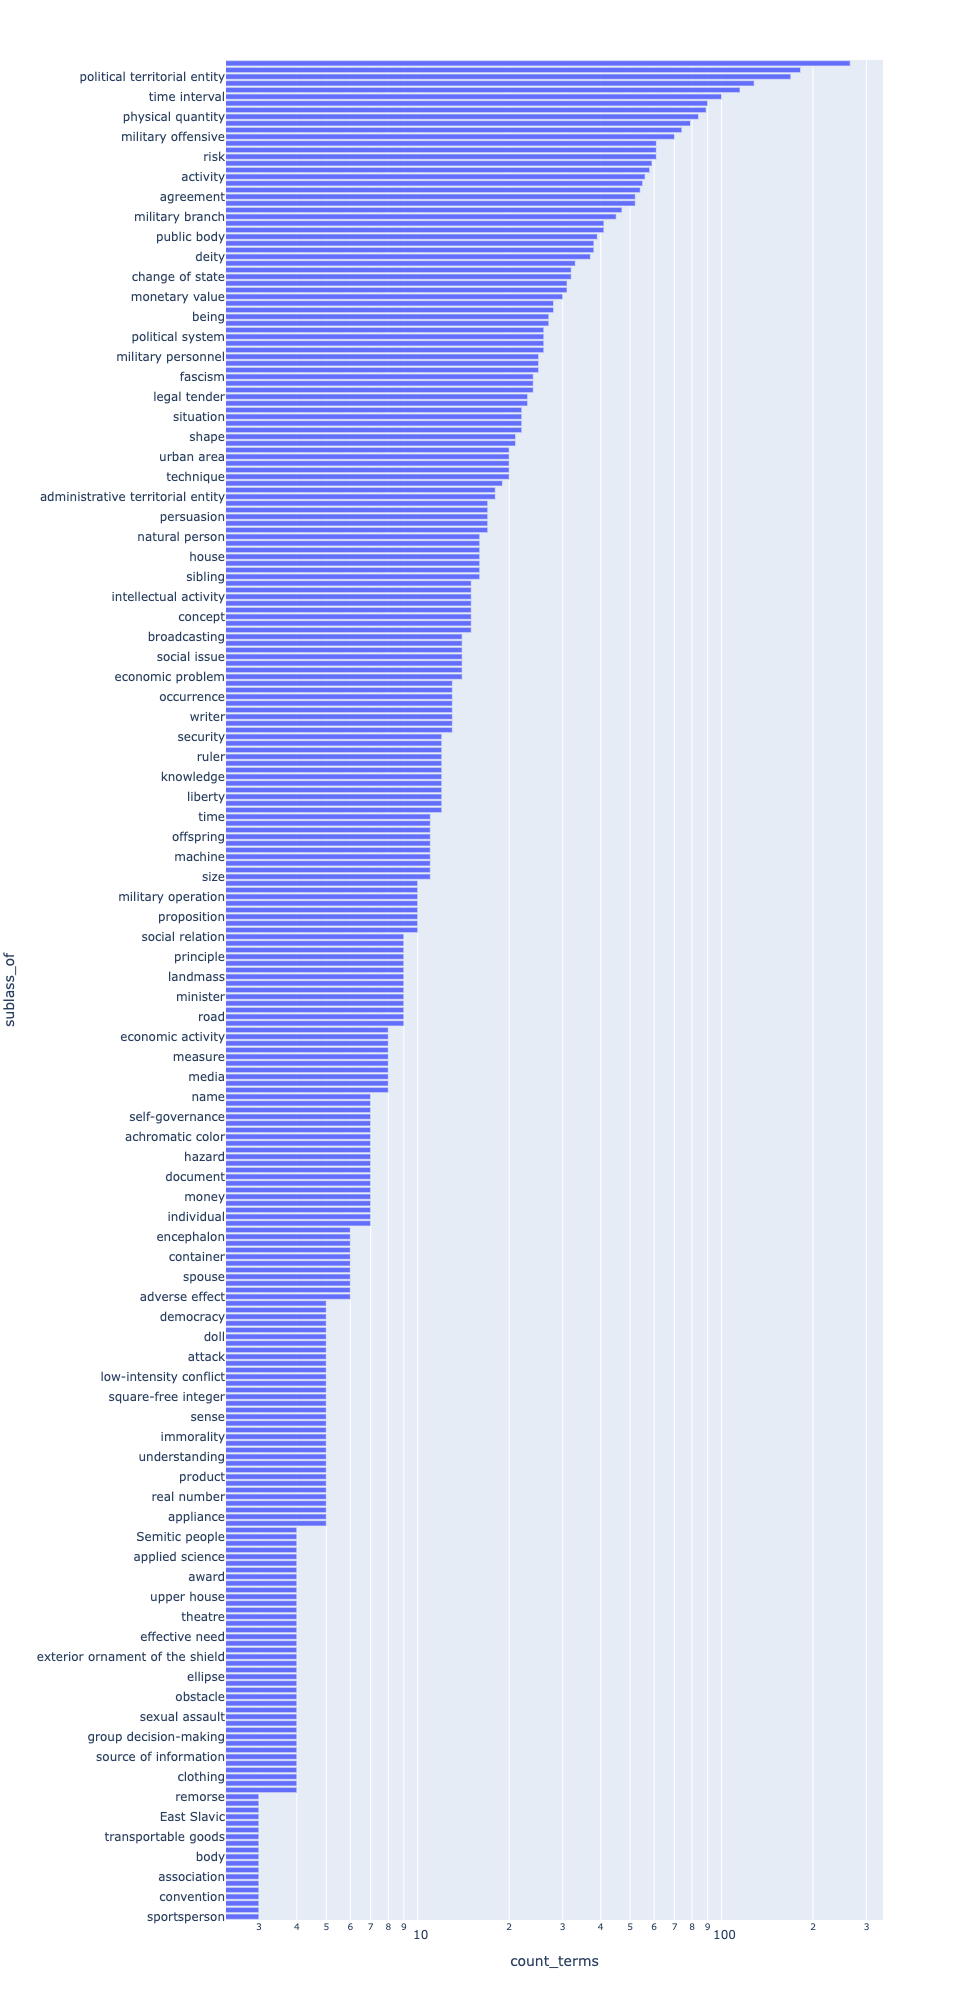

In [29]:
import plotly.express as px
fig = px.bar(test, x='count_terms', y='sublass_of', height = 2000, log_x = True)
fig.show()

In [129]:
new_terms['wiki_page'] = new_terms['wikidata_id'].progress_apply(lambda x : get_wikipedia_page_from_wikidata(x))
new_terms['wiki_abstract'] = new_terms['wiki_page'].progress_apply(lambda x : get_wiki_abstract(x))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 883/883 [04:40<00:00,  3.14it/s]


In [135]:
final = new_terms[~new_terms['wiki_abstract'].str.contains('may refer to:')]
final

wikidata_id                       instance     wiki_page  \
1        Q16502                        concept         World   
2         Q6256        territorial entity type       Country   
3          Q578                   unit of time       Century   
4      Q1805910  Wikimedia disambiguation page         Large   
5          Q198                           None           War   
..          ...                            ...           ...   
878         Q64                        capital        Berlin   
879      Q22654  Wikimedia disambiguation page      New York   
880       Q9332                           None      Behavior   
881         Q55                        country   Netherlands   
882     Q161078                           None  Urbanization   

                                         wiki_abstract  
1    In its most general sense, the term "world" re...  
2    A country is a distinct territorial body or po...  
3    A century is a period of 100 years. Centuries ...  
4    Large means of great size.\nLarge may also ref...  
5    War is an intense armed conflict between state...  
..                                                 ...  
878  Berlin ( bur-LIN, German: [bɛʁˈliːn] (listen))...  
879  New York most commonly refers to:\n\nNew York ...  
880  Behavior (American English) or behaviour is th...  
881  The Netherlands (Dutch: Nederland [ˈneːdərlɑnt...  
882  Urbanization (or urbanisation) refers to the p...  

[572 rows x 4 columns]

In [136]:
bunka_wiki = model.fit(
    final,
    text_var="wiki_abstract",
    index_var="wiki_page",
    sample_size=4000,
    sample_terms=2000,
    embeddings_model="tfidf",
    ngrams=(1, 2),
    ents=False,
    language="en",
    db_path=".",
)


Embeddings..
Reducing the vectors..
UMAP(angular_rp_forest=True, metric='cosine', n_components=5, n_neighbors=10, verbose=True)
Sat Feb 26 12:06:43 2022 Construct fuzzy simplicial set
Sat Feb 26 12:06:44 2022 Finding Nearest Neighbors
Sat Feb 26 12:06:44 2022 Finished Nearest Neighbor Search
Sat Feb 26 12:06:44 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sat Feb 26 12:06:46 2022 Finished embedding


Extract Terms: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 571/571 [00:27<00:00, 20.79it/s]


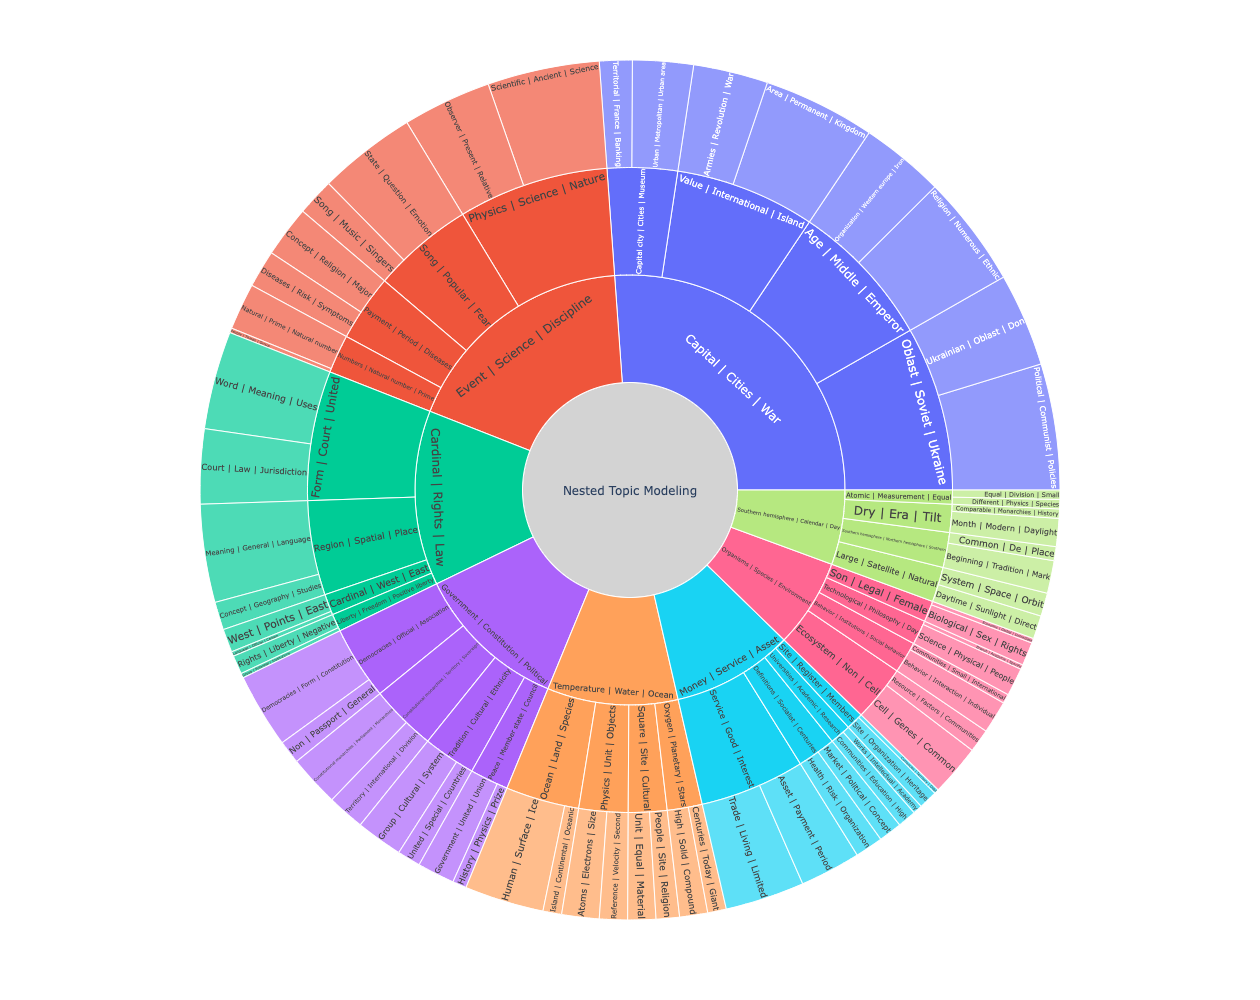

In [168]:
bunka_wiki.sunburst

In [139]:
clusters = model.h_clusters_names.copy()
clusters['lemma_0'] = clusters['level_0'].astype(str) + ' - ' +  clusters['lemma_0']
clusters['lemma_1'] = clusters['level_1'].astype(str) + ' - ' +  clusters['lemma_1']
clusters['lemma_2'] = clusters['level_2'].astype(str) + ' - ' +  clusters['lemma_2']

In [171]:
nested  = 0
cluster = 0

filtered_clusters = clusters[[f'lemma_{nested}']].drop_duplicates().reset_index(drop=True)
print(filtered_clusters)
print('')

df_centroid = model.get_centroid_documents(nested_level = nested, top_elements = 3)
test = df_centroid[df_centroid['clusters']==cluster]
text_docs = test['centroid_docs'].values[0]
docs = text_docs.split(' || ')
print(docs[0])
print('')
print(docs[1])
print('')
print(docs[2])
print('')

                                     lemma_0
0            0 - Temperature | Water | Ocean
1  1 - Government | Constitution | Political
2           2 - Event | Science | Discipline
3                3 - Cardinal | Rights | Law
4   4 - Southern hemisphere | Calendar | Day
5                 5 - Capital | Cities | War
6      6 - Organisms | Species | Environment
7                7 - Money | Service | Asset

A wall is a structure and a surface that defines an area; carries a load; provides security, shelter, or soundproofing; or, is decorative. There are many kinds of walls, including:

Walls in buildings that form a fundamental part of the superstructure or separate interior rooms, sometimes for fire safety
Glass walls (a wall in which the primary structure is made of glass; does not include openings within walls that have glass coverings: these are windows)
Border barriers between countries
Brick walls
Defensive walls in fortifications
Permanent, solid fences
Retaining walls, which hold ba